In [1]:
# 数据查看
import pandas
data = pandas.read_csv('/Users/jiaoxubin/Desktop/Purchase-Redemption-Data/user_balance_table.csv') 

In [2]:
daydf = data.groupby(['report_date'])
totaldf = daydf['total_purchase_amt','total_redeem_amt'].sum()
totaldf.head()
totaldf.to_csv('data_label.csv')

/var/folders/jd/dy4pf8d16h376hskv9jy3h1r0000gn/T/ipykernel_66321/3673561246.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  totaldf = daydf['total_purchase_amt','total_redeem_amt'].sum()


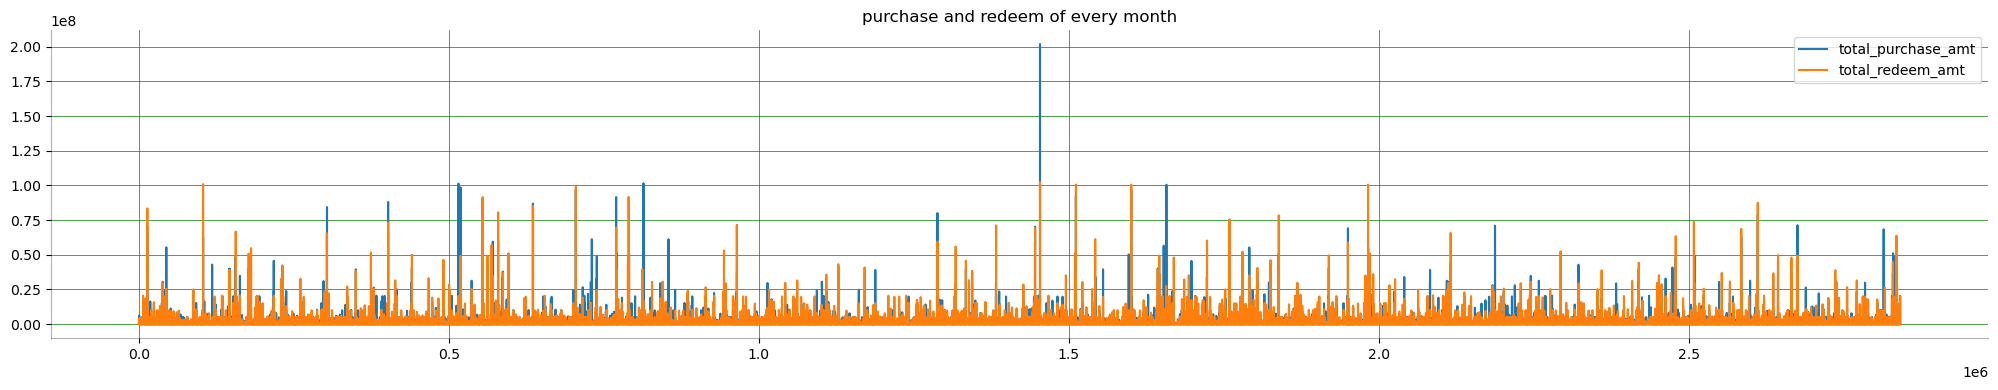

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 4)  # set figure size
data[['total_purchase_amt', 'total_redeem_amt']].plot()
plt.grid(True, linestyle="-", color="green", linewidth="0.5")
plt.legend()
plt.title('purchase and redeem of every month')

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.show()

In [16]:

# -*- coding:utf-8 -*-

"""
reference:https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
Note:
1.LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
2.The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
"""

import math
import numpy
import pandas
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import os

numpy.random.seed(2019)


class RNNModel(object):
    def __init__(self, look_back=1, epochs_purchase=20, epochs_redeem=40, batch_size=1, verbose=2, patience=10, store_result=False):
        self.look_back = look_back
        self.epochs_purchase = epochs_purchase
        self.epochs_redeem = epochs_redeem
        self.batch_size = batch_size
        self.verbose = verbose
        self.store_result = store_result
        self.patience = patience
        self.purchase = pandas.read_csv('/Users/jiaoxubin/Desktop/Purchase-Redemption-Data/user_balance_table.csv', usecols=[1], engine='python') 
        self.redeem = pandas.read_csv('/Users/jiaoxubin/Desktop/Purchase-Redemption-Data/user_balance_table.csv', usecols=[2], engine='python')
        
    def access_data(self, data_frame):
        # load the data set
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        # reshape into X=t and Y=t+1
        train_x, train_y, test = self.create_data_set(data_set)

        # reshape input to be [samples, time steps, features]
        train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

    # convert an array of values into a data set matrix
    def create_data_set(self, data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-self.look_back - 30):
            a = data_set[i:(i + self.look_back), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + self.look_back: i + self.look_back + 30, 0]))
        # print(numpy.array(data_y).shape)
        return numpy.array(data_x), numpy.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)

    def rnn_model(self, train_x, train_y, epochs):
        model = Sequential()
        model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(32))
        model.add(Dense(30))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        early_stopping = EarlyStopping('loss', patience=self.patience)
        history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
        return model

    def predict(self, model, data):
        prediction = model.predict(data)
        return prediction

    def plot_show(self, predict):
        predict = predict[['purchase', 'redeem']]
        predict.plot()
        plt.show()

    def run(self):
        purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = self.access_data(self.purchase)
        redeem_train_x, redeem_train_y, redeem_test, redeem_scaler = self.access_data(self.redeem)

        purchase_model = self.rnn_model(purchase_train_x, purchase_train_y, self.epochs_purchase)
        redeem_model = self.rnn_model(redeem_train_x, redeem_train_y, self.epochs_redeem)

        purchase_predict = self.predict(purchase_model, purchase_test)
        redeem_predict = self.predict(redeem_model, redeem_test)

        test_user = pandas.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})

        purchase = purchase_scaler.inverse_transform(purchase_predict).reshape(30, 1)
        redeem = redeem_scaler.inverse_transform(redeem_predict).reshape(30, 1)

        test_user['purchase'] = purchase
        test_user['redeem'] = redeem
        print(test_user)

        """Store submit file"""
        if self.store_result is True:
            test_user.to_csv('submit_lstm.csv', encoding='utf-8', index=None, header=None)
            
        """plot result picture"""
        self.plot_show(test_user)
        
if __name__ == '__main__':
    initiation = RNNModel(look_back=40, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
    initiation.run()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             26880     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 30)                990       
                                                                 
Total params: 41342 (161.49 KB)
Trainable params: 41342 (161.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150


KeyboardInterrupt: 